# Plot the output of count_events.py

In [2]:
#import python packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import oskar

### Import data

In [3]:
rid = '20160318_153639'
h5 = oskar.H5Data(rid)              # data
out_dire = h5.out_dire("Count")     # output
# log 
h5.load_log()
logDF = h5.log
varDF = h5.vDF()
uDF = h5.uDF()
# count data
NAMES = ['CH_A0', 'CH_A1']
allDF = h5.load_count(NAMES, include_vars=True)

In [4]:
uDF

,DLY_EA,IR,UV,VOL_u100,VOL_u101
VID,,,,,
1,5.950000e-07,735.6035,243.2,2000,2000
2,5.950000e-07,736.4084,243.2,2000,2000
3,5.950000e-07,737.3534,243.2,2000,2000
4,5.950000e-07,738.4732,243.2,2000,2000
5,5.950000e-07,739.8138,243.2,2000,2000
6,5.950000e-07,741.4379,243.2,2000,2000
7,5.950000e-07,743.4321,243.2,2000,2000
8,5.950000e-07,745.9188,243.2,2000,2000
9,5.950000e-07,749.0765,243.2,2000,2000


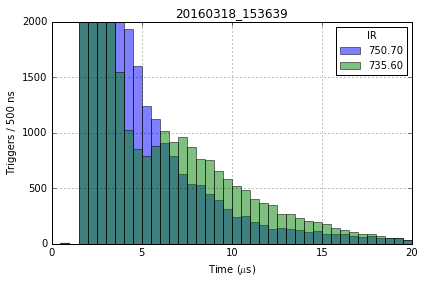

In [6]:
## plot setup
fig, ax = plt.subplots()
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

max_amp = 0.025
max_width = 0.5e-6

# select data
VIDS = [10, 1]
for vid in VIDS:
    # select data
    data = allDF[((allDF[uDF.columns] == uDF.loc[vid]).all(1))]
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values)*1e6
    ax.hist(trigs, bins=bins, alpha=0.5, label='%.2f'%uDF.loc[vid, 'IR'])
    
#format
plt.axhline(0, color='k', alpha=0.5)
lgd = ax.legend(loc=0, fontsize=10, title='IR')
ax.set_ylabel("Triggers / 500 ns");
ax.set_xlabel(r"Time ($\mu$s)");
ax.set_ylim(0,2000)
plt.title(rid);
ax.grid(True)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_triggers.png')
plt.savefig(fileout, dpi=150)

In [24]:
import f2mods as f2
from positronium.constants import Ryd_Ps
from scipy.constants import m_e, k, micro
from lmfit import minimize, Parameters, report_fit
def n_val(IR):
    return np.sqrt(-1.0/(1.0/ (IR * Ryd_Ps) - 0.25))

In [15]:
t0 = 2.22e-06

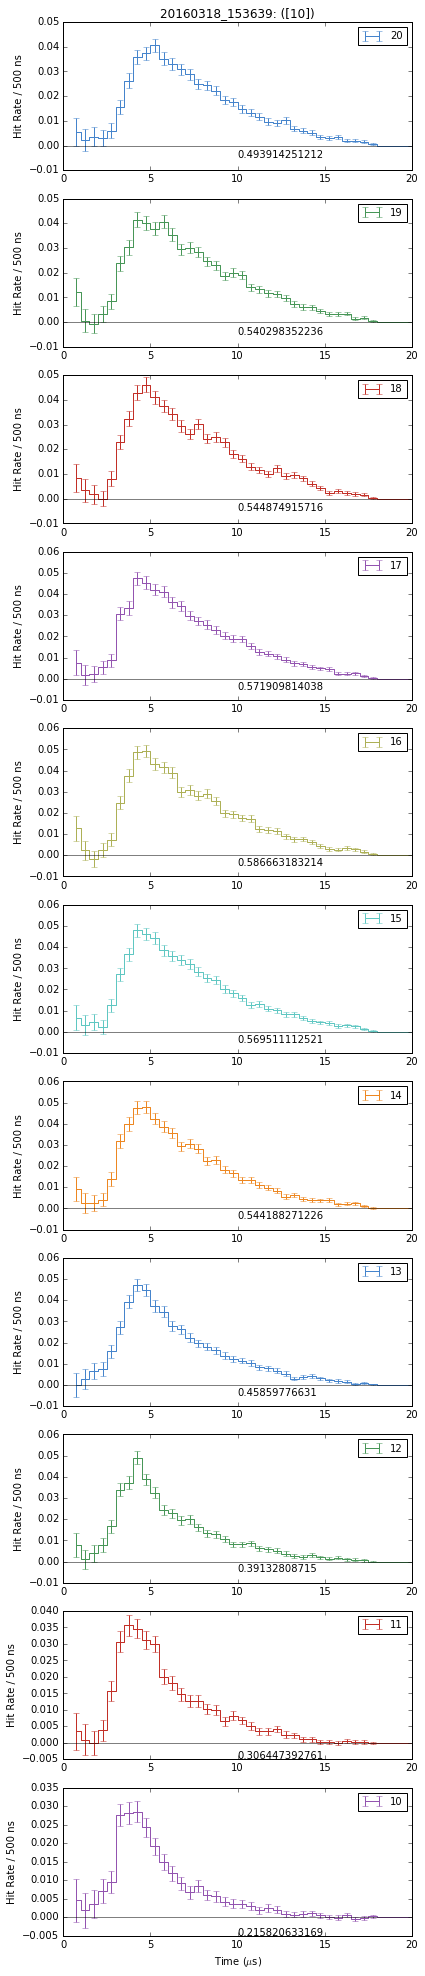

In [210]:
# histogram bins
bin_width = 0.5
bins=np.arange(0.5,20 + bin_width, bin_width)

# background
vid_off = [10]
# select data
data = allDF[(allDF[uDF.columns] == uDF.loc[vid_off[0]]).all(1)]
acq_off = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
# cut triggers
data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
trigs = (data['trigger'].values - t0)*1e6
n_off = np.histogram(trigs, bins=bins)
x = n_off[1][:-1]+bin_width/2

# data
VIDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]
n_rows = len(VIDS)
#plot setup
fig, ax = plt.subplots(n_rows, 1, figsize=(6,2.5*n_rows))
ax = np.array([ax]).flatten()
j = 0
hr = []
n_values = []
all_data = []
all_err = []
zero_err = 0.0005
for vid in VIDS:
    # delay 1
    # select data
    data = allDF[(allDF[uDF.columns] == uDF.loc[vid]).all(1)]
    acq_on = logDF.loc[np.unique(data.squid.values), 'ACQUIRE'].sum()
    # cut triggers
    data = data[(data['amp'] < max_amp) & (data['width'] < max_width)]
    trigs = (data['trigger'].values - t0)*1e6
    n_on = np.histogram(trigs, bins=bins)
    # normalise and subtract background
    y =  np.subtract(n_on[0]/ acq_on, n_off[0] / acq_off)
    yerr  = np.add(np.sqrt(n_on[0])/ acq_on, np.sqrt(n_off[0])/ acq_off)
    n = (round(n_val(f2.rad_cal(uDF.loc[vid].IR) * 1e-9)))
    n_values.append(n)
    ax[j].errorbar(x, y, yerr=yerr, drawstyle='steps-mid', color=oskar.colors[j%7], label='%d'%n)
    ax[j].legend(loc=0, fontsize=10)
    ax[j].set_ylabel("Hit Rate / 500 ns")
    ax[j].axhline(0, color='k', alpha=0.5)
    ax[j].text(10, -0.005,y[5:].sum())
    hr.append(y[4:].sum())
    # collect data
    all_data.append(y)
    fear = np.array([zero_err if ye == 0 else ye for ye in yerr])
    all_err.append(fear)
    j = j + 1

all_data = np.array(all_data)
all_err = np.array(all_err)
assert(all_data.shape) == np.shape(all_data)

# format
ax[-1].set_xlabel(r"Time ($\mu$s)");
ax[0].set_title(rid + ': (' + str(vid_off) + ')');

# save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_bsub.png')
plt.savefig(fileout, dpi=150)
plt.show()

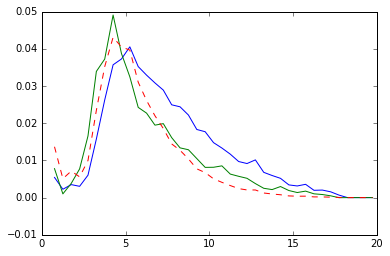

In [212]:
A = 2.95
tau = 4.757
plt.plot(x, all_data[0])
plt.plot(x, all_data[-3])
plt.plot(x, A * all_data[0] * np.exp(-x / tau), ls='--')

In [213]:
fit_params = Parameters()
fit_params.add( 'A', value=1.5, min=1.0,  max=3)
fit_params.add( 'tau', value=10, min=0.1,  max=200)

def objective(params, x, data0, data):
    tau0 = 25
    A = params['A'].value
    tau = params['tau'].value
    return data * np.exp(-x / tau0) - A * data0 * np.exp(-x / tau)

In [214]:
tau_val = []
tau_err = []
A_val = []
A_err = []
for i in range(11):
    fit = minimize(objective, fit_params, args=(x, all_data[0], all_data[i]))
    tau_val.append(fit.params.get('tau').value)
    tau_err.append(fit.params.get('tau').stderr)
    A_val.append(fit.params.get('A').value)
    A_err.append(fit.params.get('A').stderr)

In [215]:
fits4 = [tau_val, tau_err]

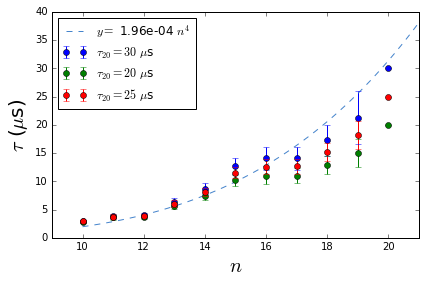

In [216]:
#fit
from scipy.optimize import curve_fit
def h(n, *p):
    alpha = p
    f = alpha * n**4
    return f

# guess
p0 = [10]
xf = np.arange(10, 22, 0.2)
# fit
coeff, cov = curve_fit(h, n_values[1:], tau_val[1:], p0=p0, sigma=tau_err[1:])
y3 = h(xf, *coeff)
plt.plot(xf, y3, c=oskar.colors[0], ls='--', label = r'$y = $ %.2e $n^4$'%coeff[0])

plt.errorbar(n_values, fits[0], yerr=fits[1], fmt='o', label=r'$\tau_{20} = 30$ $\mu$s')
#plt.errorbar(n_values, fits3[0], yerr=fits3[1], fmt='o', label=r'$\tau_{20} = 50$ $\mu$s')
plt.errorbar(n_values, fits2[0], yerr=fits2[1], fmt='o', label=r'$\tau_{20} = 20$ $\mu$s')
plt.errorbar(n_values, fits4[0], yerr=fits2[1], fmt='o', label=r'$\tau_{20} = 25$ $\mu$s')
plt.legend(loc=0)
plt.xlabel(r'$n$', fontsize=20) 
plt.ylabel(r'$\tau$ ($\mu$s)', fontsize=20)
plt.ylim(0,40)
plt.xlim(9,21)
# save data
plt.tight_layout();
fileout = os.path.join(out_dire, "_".join(NAMES) + '_tau.png')
plt.savefig(fileout, dpi=150)
plt.show()

<Container object of 3 artists>

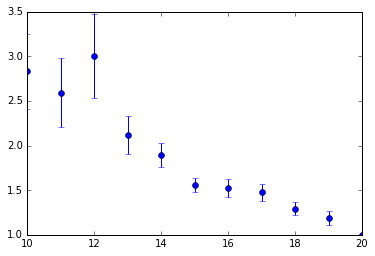

In [217]:
plt.errorbar(n_values,A_val, yerr=A_err, fmt='o')